# Solução desenvolvida

## Preparação de ambiente

In [1]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# caso instalar algo novo
!pip3 freeze > requiremets.txt

In [ ]:
# imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Definições e declarações

In [2]:
# Estados
STATE_HIGH = "Bateria Alta"
STATE_LOW = "Bateria Baixa"

# Ações
ACTION_SEARCH = "Procurar"
ACTION_WAIT = "Esperar"
ACTION_RECHARGE = "Recarregar"

Definindo abaixo as probabilidades de transição:

In [3]:
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

Parâmetros de treinamento:

In [13]:
NUM_EPOCHS = 100               # Número de épocas de treinamento
STEPS_PER_EPOCH = 1000         # Passos de tempo por época
REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

Criando classes para modelar o problema:

In [52]:
class Environment:
    """
    Simula o ambiente do robô de reciclagem.
    Gerencia as transições de estado e as recompensas com base nas ações do robô.
    """
    def get_available_actions(self, state):
        """ Retorna as ações possíveis para um dado estado. """
        if state == STATE_HIGH:
            return [ACTION_SEARCH, ACTION_WAIT]
        else: # STATE_LOW
            return [ACTION_SEARCH, ACTION_WAIT, ACTION_RECHARGE]

    def step(self, state, action):
        """
        Executa uma ação e retorna o próximo estado e a recompensa.
        A lógica de transição é baseada nas probabilidades alfa e beta.
        """
        if state == STATE_HIGH:
            if action == ACTION_SEARCH:
                # Transição estocástica ao procurar com bateria alta
                if np.random.rand() < ALPHA_PROB:
                    next_state = STATE_HIGH
                else:
                    next_state = STATE_LOW
                return next_state, R_SEARCH
            elif action == ACTION_WAIT:
                # Ficar em espera mantém o estado e dá uma recompensa menor
                return STATE_HIGH, R_WAIT

        elif state == STATE_LOW:
            if action == ACTION_RECHARGE:
                # Recarregar sempre leva ao estado de bateria alta
                return STATE_HIGH, R_RECHARGE
            elif action == ACTION_WAIT:
                 # Ficar em espera mantém o estado de bateria baixa
                return STATE_LOW, R_WAIT
            elif action == ACTION_SEARCH:
                # Procurar com bateria baixa tem risco de precisar de resgate
                if np.random.rand() < 1-BETA_PROB:
                    # Acabou a bateria e o robô foi resgatado
                    return STATE_HIGH, R_RESCUE
                else:
                    # Continua procurando com bateria baixa
                    return STATE_LOW, R_SEARCH

        # Caso uma ação inválida seja fornecida
        raise ValueError(f"Ação '{action}' inválida para o estado '{state}'")

class Agent:
    """
    O agente que aprende a política ótima usando Q-learning (um método TD).
    """
    def __init__(self, learning_rate=LEARNING_RATE, discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON):
        self.q_values = {}  # Dicionário para armazenar os valores Q(s, a)
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.environment = Environment()

    def get_q_value(self, state, action):
        """ Acessa o valor Q para um par (estado, ação), retornando 0 se não existir. """
        return self.q_values.get((state, action), 0.0)

    def choose_action(self, state):
        """
        Escolhe uma ação usando uma política epsilon-greedy.
        - Com probabilidade (1 - epsilon), escolhe a melhor ação (explotação).
        - Com probabilidade epsilon, escolhe uma ação aleatória (exploração).
        """
        available_actions = self.environment.get_available_actions(state)
        if np.random.rand() < self.epsilon:
            # Exploração: escolhe uma ação aleatória
            return np.random.choice(available_actions)
        else:
            # Explotação: escolhe a melhor ação com base nos valores Q
            q_vals = [self.get_q_value(state, a) for a in available_actions]
            return available_actions[np.argmax(q_vals)]

    def update(self, state, action, reward, next_state):
        """
        Atualiza o valor Q para o par (estado, ação) usando a regra do Q-learning.
        Q(s, a) <- Q(s, a) + lr * [R + gamma * max_a'(Q(s', a')) - Q(s, a)]
        """
        # Encontra o valor Q máximo para o próximo estado
        next_available_actions = self.environment.get_available_actions(next_state)
        max_next_q = max([self.get_q_value(next_state, a) for a in next_available_actions])

        # Calcula o TD target e o erro
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - self.get_q_value(state, action)

        # Atualiza o valor Q
        new_q_value = self.get_q_value(state, action) + self.lr * td_error
        self.q_values[(state, action)] = new_q_value

    def save_policy(self, filename="policy.pkl"):
        """ Salva o dicionário de valores Q em um arquivo. """
        with open(filename, 'wb') as f:
            pickle.dump(self.q_values, f)
        print(f"Política salva em {filename}")

    def load_policy(self, filename="policy.pkl"):
        """ Carrega o dicionário de valores Q de um arquivo. """
        with open(filename, 'rb') as f:
            self.q_values = pickle.load(f)
        print(f"Política carregada de {filename}")

def train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON):
    """
    Função principal para treinar o agente.
    """
    agent = Agent(discount_factor=discount_factor, epsilon=epsilon)
    env = Environment()
    total_rewards_per_epoch = []

    # Abre o arquivo para salvar as recompensas
    with open(REWARD_FILE, 'w') as f_rewards:
        print("Iniciando o treinamento...")
        for epoch in range(NUM_EPOCHS):
            current_state = STATE_HIGH  # Robô sempre começa com bateria alta
            total_epoch_reward = 0

            for step in range(STEPS_PER_EPOCH):
                # 1. Agente escolhe uma ação
                action = agent.choose_action(current_state)

                # 2. Ambiente retorna o próximo estado e a recompensa
                next_state, reward = env.step(current_state, action)

                # 3. Agente atualiza seus valores Q
                agent.update(current_state, action, reward, next_state)

                # 4. Atualiza o estado e acumula a recompensa
                current_state = next_state
                total_epoch_reward += reward

            # Salva e imprime o progresso
            total_rewards_per_epoch.append(total_epoch_reward)
            f_rewards.write(f"{total_epoch_reward}\n")
            if (epoch + 1) % 10 == 0:
                print(f"Época {epoch + 1}/{NUM_EPOCHS} | Recompensa Total: {total_epoch_reward}")

    agent.save_policy()
    print("Treinamento concluído.")
    return agent.q_values

def plot_rewards(reward_file=REWARD_FILE, DIR = "", NAME="rewards_plot.png"):
    """
    Lê o arquivo de recompensas e plota a curva de aprendizado.
    """
    rewards = np.loadtxt(reward_file)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(rewards) + 1), rewards, marker='o', linestyle='-')
    plt.title("Recompensa Total Acumulada por Época")
    plt.xlabel("Época")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.savefig(DIR+NAME)
    print("Gráfico de recompensas salvo em 'rewards_plot.png'")
    # plt.show()

def plot_policy_heatmap(q_values, DIR = "", NAME="policy_heatmap.png"):
    """
    Cria um heatmap para visualizar a política ótima aprendida.
    """
    states = [STATE_HIGH, STATE_LOW]
    actions = [ACTION_SEARCH, ACTION_WAIT, ACTION_RECHARGE]

    # Extrai a ação ótima para cada estado
    policy = {}
    for state in states:
        available_actions = Environment().get_available_actions(state)
        q_vals = [q_values.get((state, a), 0.0) for a in available_actions]
        best_action = available_actions[np.argmax(q_vals)]
        policy[state] = best_action

    # Mapeia ações para números para o heatmap
    action_map = {ACTION_SEARCH: 0, ACTION_WAIT: 1, ACTION_RECHARGE: 2}
    policy_matrix = np.full((len(states), len(actions)), np.nan) # Preenche com NaN

    for i, state in enumerate(states):
        best_action = policy[state]
        action_idx = action_map[best_action]
        policy_matrix[i, action_idx] = q_values.get((state, best_action), 0)

    # Cria o heatmap
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(policy_matrix,
                     annot=True,
                     fmt=".2f",
                     cmap="viridis",
                     xticklabels=actions,
                     yticklabels=states,
                     linewidths=.5,
                     cbar_kws={'label': 'Valor Q da Ação Ótima'})

    ax.set_title("Política Ótima do Robô de Reciclagem", fontsize=16)
    plt.xlabel("Ações", fontsize=12)
    plt.ylabel("Estados", fontsize=12)
    plt.yticks(rotation=0)

    # Destaca a ação ótima
    for i, state in enumerate(states):
        action_idx = action_map[policy[state]]
        ax.add_patch(plt.Rectangle((action_idx, i), 1, 1, fill=False, edgecolor='red', lw=3))

    plt.tight_layout()
    plt.savefig(DIR+NAME)
    print("Heatmap da política salvo em 'policy_heatmap.png'")
    # plt.show()

## Treinando o modelo e testando

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7034
Época 20/100 | Recompensa Total: 7010
Época 30/100 | Recompensa Total: 6925
Época 40/100 | Recompensa Total: 7057
Época 50/100 | Recompensa Total: 7059
Época 60/100 | Recompensa Total: 7031
Época 70/100 | Recompensa Total: 7150
Época 80/100 | Recompensa Total: 7046
Época 90/100 | Recompensa Total: 7002
Época 100/100 | Recompensa Total: 7099
Política salva em policy.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'rewards_plot.png'
Heatmap da política salvo em 'policy_heatmap.png'


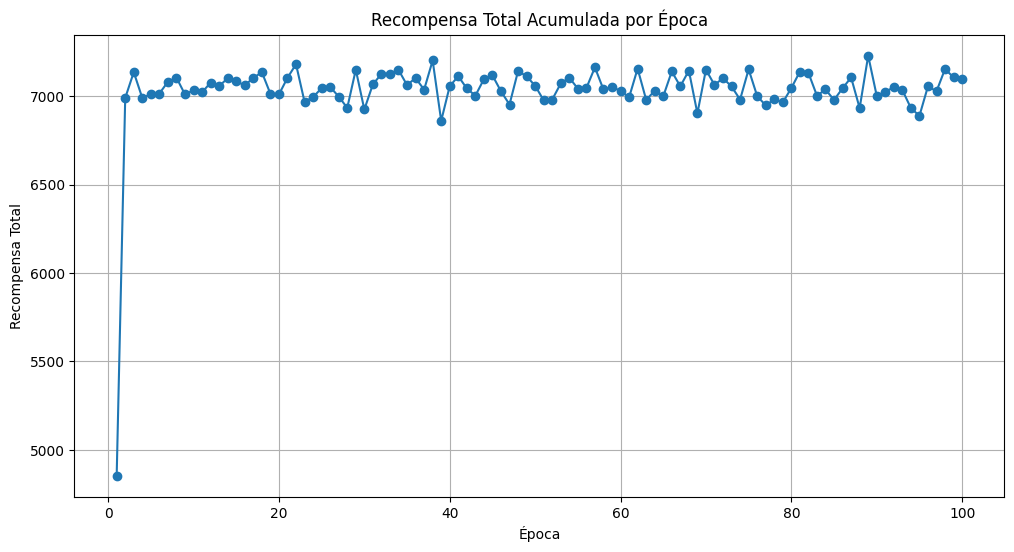

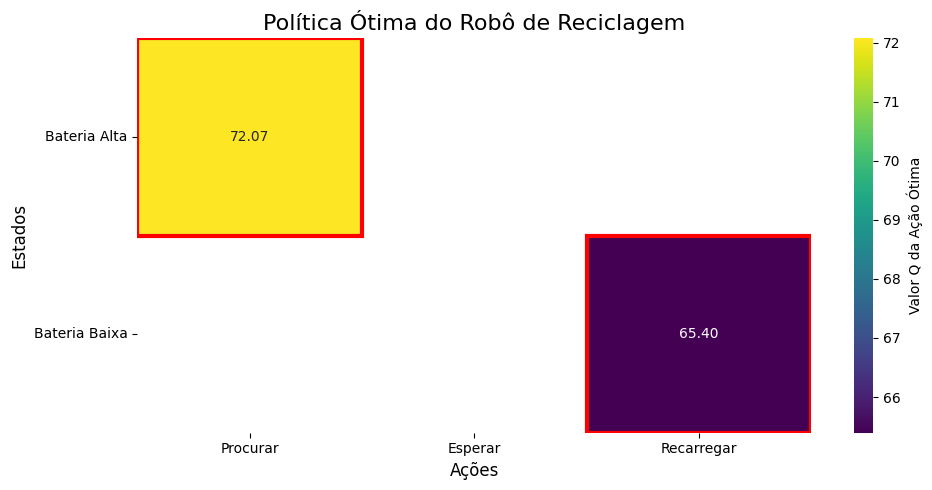

In [53]:
np.random.seed(0)
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

# treinando com variaveis globais pré estabelecidas
final_q_values = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON)
plot_rewards()
plot_policy_heatmap(final_q_values)

Rodando para vários hiperparâmetros e anotando heatmaps e rewards

Testando:
- epsilon-greedy vs greedy
- diferentes valores de alpha e beta
- efeito de gamma baixo (0.5)

### epsilon-greedy vs greedy

#### epsilon-Greedy

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7034
Época 20/100 | Recompensa Total: 7010
Época 30/100 | Recompensa Total: 6925
Época 40/100 | Recompensa Total: 7057
Época 50/100 | Recompensa Total: 7059
Época 60/100 | Recompensa Total: 7031
Época 70/100 | Recompensa Total: 7150
Época 80/100 | Recompensa Total: 7046
Época 90/100 | Recompensa Total: 7002
Época 100/100 | Recompensa Total: 7099
Política salva em policy.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'rewards_plot.png'
Heatmap da política salvo em 'policy_heatmap.png'


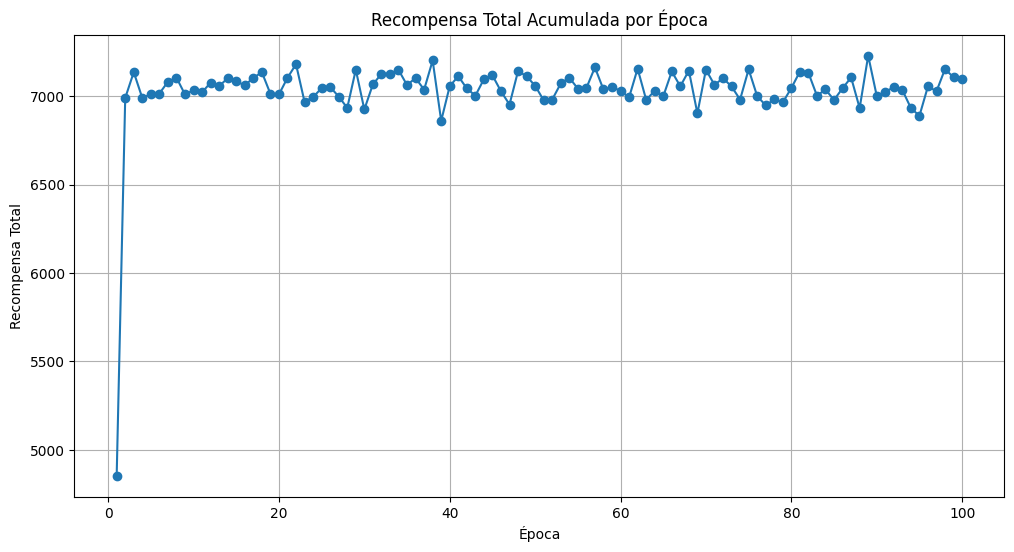

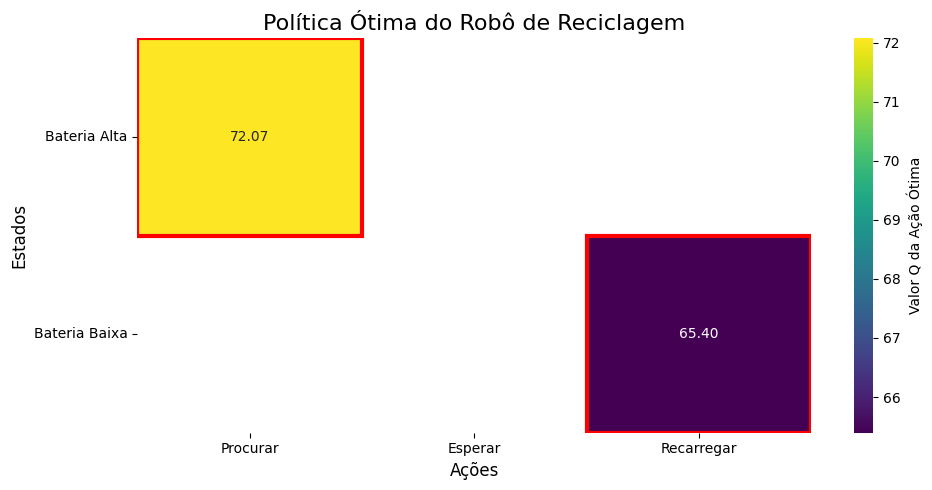

In [54]:
np.random.seed(0)
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

# treinando com variaveis globais pré estabelecidas
final_q_values = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON)
plot_rewards()
plot_policy_heatmap(final_q_values)

#### greedy

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 3055
Época 20/100 | Recompensa Total: 3025
Época 30/100 | Recompensa Total: 3070
Época 40/100 | Recompensa Total: 3035
Época 50/100 | Recompensa Total: 3005
Época 60/100 | Recompensa Total: 3015
Época 70/100 | Recompensa Total: 3050
Época 80/100 | Recompensa Total: 3045
Época 90/100 | Recompensa Total: 3035
Época 100/100 | Recompensa Total: 3020
Política salva em policy.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'rewards_plot.png'
Heatmap da política salvo em 'policy_heatmap.png'


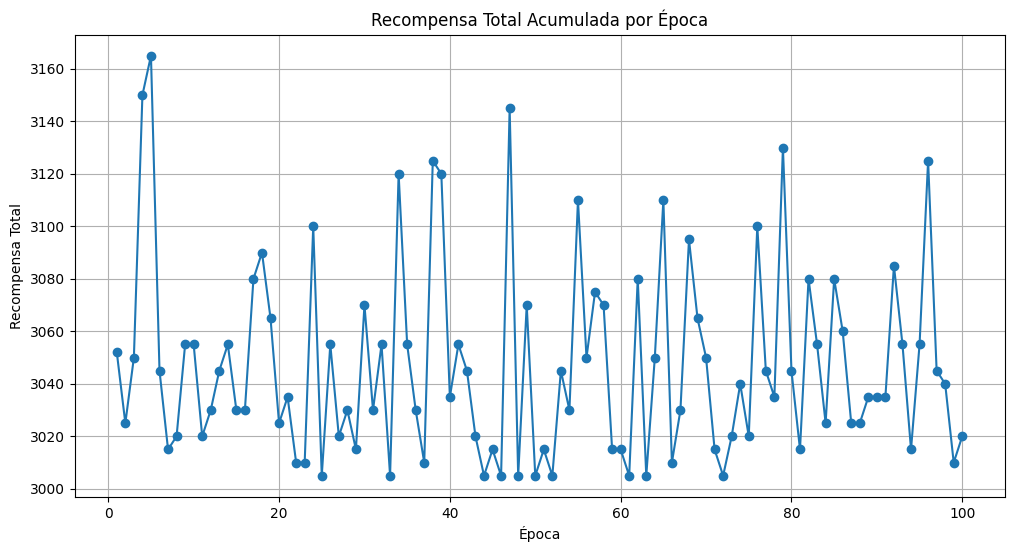

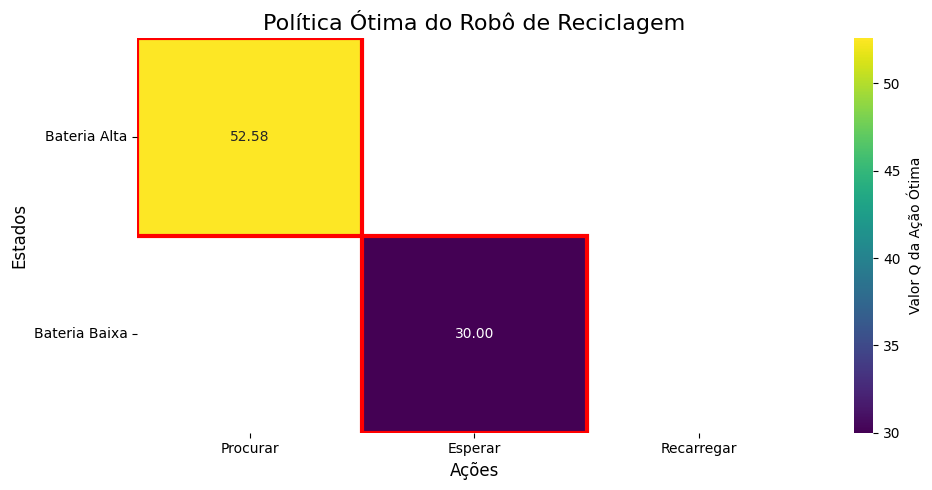

In [55]:
np.random.seed(0)
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.0         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

# treinando com variaveis globais pré estabelecidas
final_q_values = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON)
plot_rewards()
plot_policy_heatmap(final_q_values)

### Testando diferentes discount factors

#### discount factor em 0.5

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7040
Época 20/100 | Recompensa Total: 6979
Época 30/100 | Recompensa Total: 6902
Época 40/100 | Recompensa Total: 7057
Época 50/100 | Recompensa Total: 6998
Época 60/100 | Recompensa Total: 7047
Época 70/100 | Recompensa Total: 7140
Época 80/100 | Recompensa Total: 7036
Época 90/100 | Recompensa Total: 6976
Época 100/100 | Recompensa Total: 7097
Política salva em policy.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'rewards_plot.png'
Heatmap da política salvo em 'policy_heatmap.png'


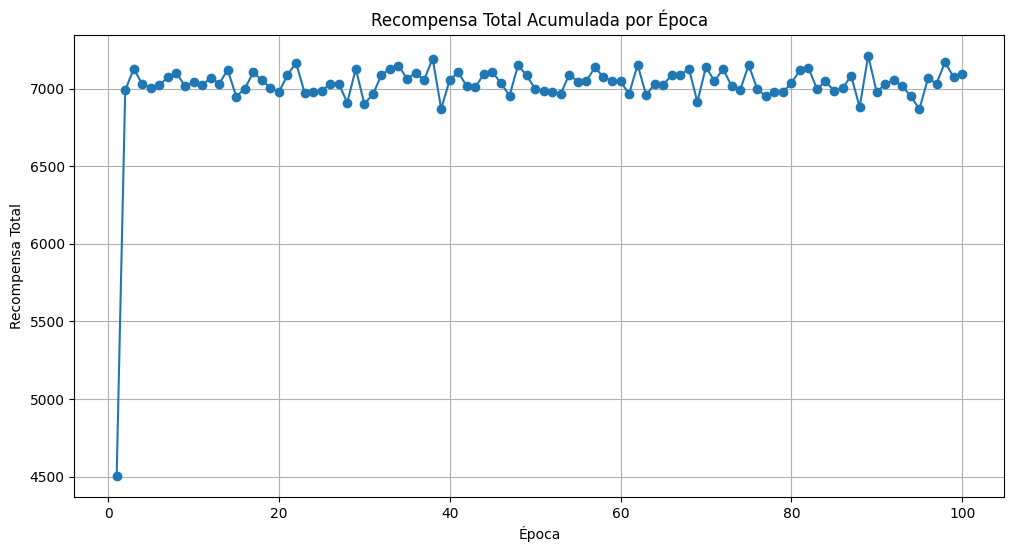

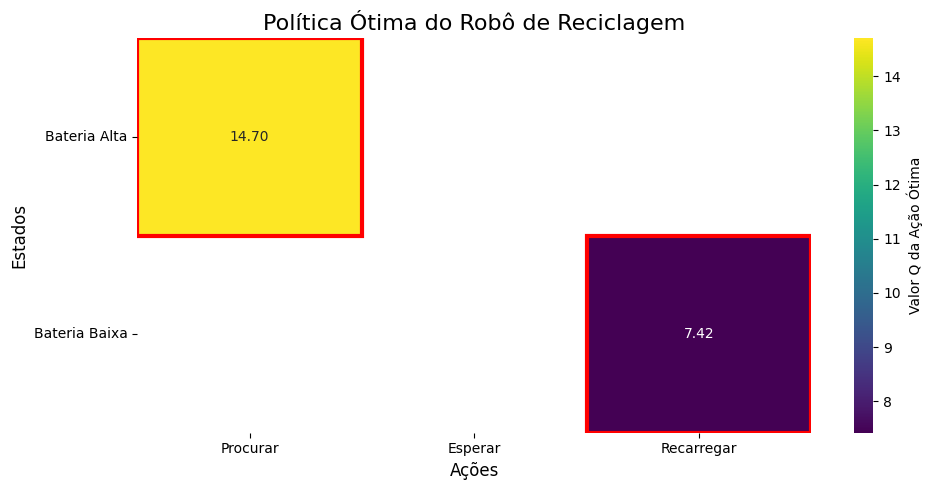

In [57]:
np.random.seed(0)
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.5 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

# treinando com variaveis globais pré estabelecidas
final_q_values = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON)
plot_rewards()
plot_policy_heatmap(final_q_values)

#### discount factor em 0.8

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7006
Época 20/100 | Recompensa Total: 7002
Época 30/100 | Recompensa Total: 6960
Época 40/100 | Recompensa Total: 7092
Época 50/100 | Recompensa Total: 7064
Época 60/100 | Recompensa Total: 7049
Época 70/100 | Recompensa Total: 7128
Época 80/100 | Recompensa Total: 7019
Época 90/100 | Recompensa Total: 6973
Época 100/100 | Recompensa Total: 7110
Política salva em policy.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'rewards_plot.png'
Heatmap da política salvo em 'policy_heatmap.png'


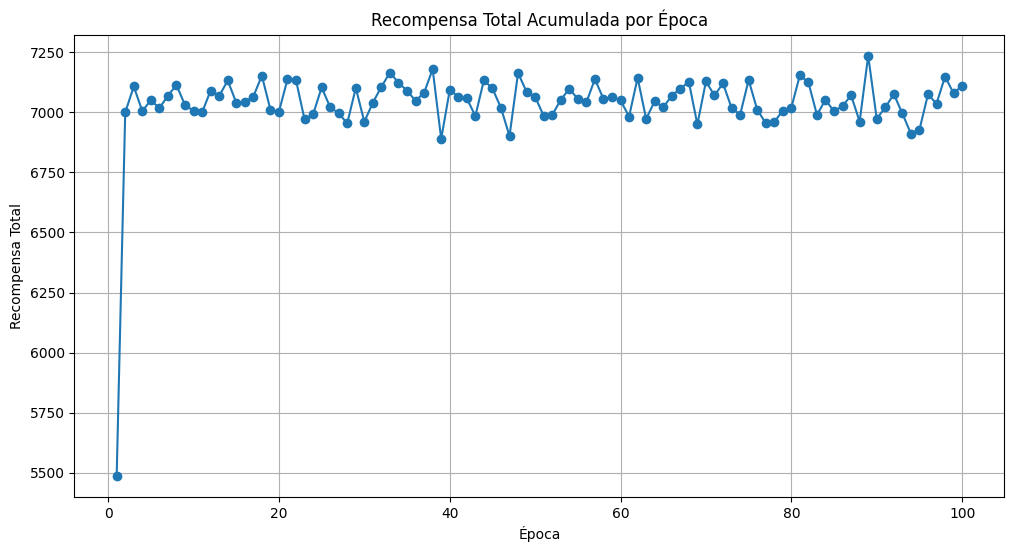

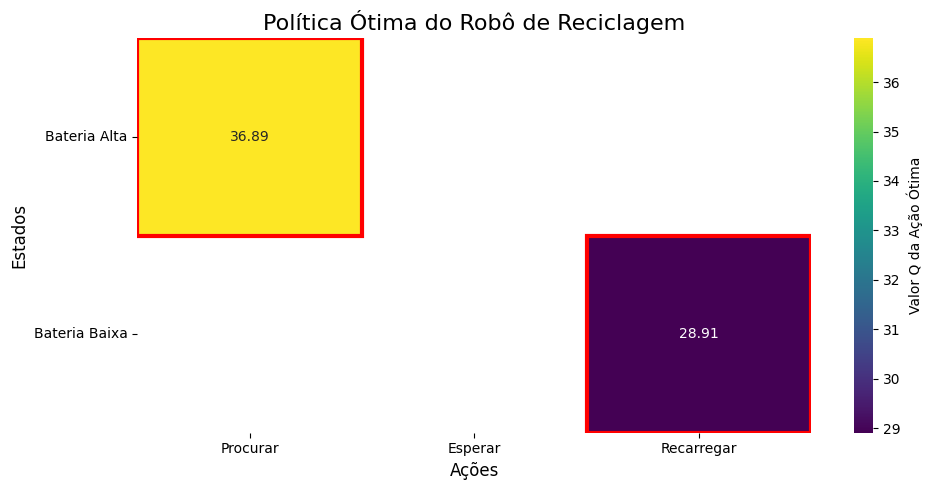

In [58]:
np.random.seed(0)
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 3        # Recompensa por esperar
R_RESCUE = -10    # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

# Hiperparâmetros do Agente
LEARNING_RATE = 0.1   # Taxa de aprendizado (alpha no TD)
DISCOUNT_FACTOR = 0.8 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards.txt"    # Arquivo para salvar as recompensas em rodada única
DIR = ""

# treinando com variaveis globais pré estabelecidas
final_q_values = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON)
plot_rewards()
plot_policy_heatmap(final_q_values)

### diferentes valores de alpha e beta

####

A fazer: 
- corrigir heatmap
- fazer plot grandao com varias iterações??